# Simulation of a positron-induced Muon Source (part 1)


### Authors:
* Saverio Monaco
* Marianna Zeragic De Giorgio
* Javier Gerardo Carmona
* Hilario Capettini 

### Description

The production of a high brillance muon beam is one of the most important challenge for the future of Particle Physics. A particularly interesting idea consists of shooting high energy positrons on a target, aiming at the production of muons by means of the process $e^+ + e^- \rightarrow \mu^+ + \mu^-$. To mimize the divergence of the resulting "muon beam", the positrons energy is chosen so that the reaction occurs close to threshold (assuming the electrons in the target to be at rest). The main goal of this project is to produce a Monte Carlo simulation of such a process. 


### References

* [LEMMA](https://arxiv.org/pdf/1509.04454.pdf) paper. The original paper describing the positron-induced low emittance muon source, ehere all the relevant kinematic features of the process have been studied
* [Babayaga](https://www2.pv.infn.it/~hepcomplex/babayaga.html) event generator. You may want to install and run it as a comparison for your results.
* [2018 Experiment](https://arxiv.org/pdf/1909.13716.pdf): the paper describing the (very poor..) results of the experiment carried out in summer 2018
* [2021 proposal](https://cds.cern.ch/record/2712394?ln=en): the proposal for the experiment in 2021
* [MANDL] Mandl F., Shaw G. _Quantum Field Theory_

### Contact

* Marco Zanetti <marco.zanetti@unipd.it>
* Camilla Curatolo <camilla.curatolo@pd.infn.it>
* Jacopo Pazzini <jacopo.pazzini@unipd.it>
* Alberto Zucchetta <alberto.zucchetta@pd.infn.it>

In [1]:
#Import the required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.integrate as integrate
import csv
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
import math

## Analytical part

1. Compute the process leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$ and with the  center of mass energy $\sqrt{s}$ as a parameter. Start by computing it in the center of mass system. N.B.: textbooks reports such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is clearly not the case here ($\sqrt{s}\sim 2m_\mu$);

2. compute and display the angle and momentum components distributions of the emerging muon pairs;

3. boost muons four-momenta in the laboratory frame, i.e. in the frame where the electron is at rest and the positron has enough energy to give rise to the process;

In [2]:
#Define the universal constants
muon_mass       = 0.1056583745       #[GeV]
electron_mass   = 0.00051099894      #[GeV]
alpha           = 0.007297           #[]            
Avogadro_number = 6.02214076e23      #[#/mol]
#Conversion constants
gev_to_ub       = 389.379            #[GeV^{-2}]
deg             = 180/np.pi          #[deg/rad]


The differential cross section was obtained from [MANDL] and it is  

$$\left(\frac{d\sigma}{d\Omega}\right)_{CM}=\frac{2\,\alpha^2}{s^2}\frac{|p'|}{\sqrt{s}}\left(\frac{s}{4}+p'^2\cos^2\vartheta+m_\mu^2\right)$$

Using the relativistic total energy expression  $$E_{CM}^2=4p'^2+4m_\mu^2\rightarrow p'^2=\frac{E_{CM}^2}{4}-m_\mu^2\rightarrow p'^2=\frac{s}{4}-m_\mu^2$$

The differential cross section can be rewritten as:
$$\left(\frac{d\sigma}{d\Omega}\right)_{CM}=\frac{2\,\alpha^2}{s}\sqrt{\frac{1}{4}-\frac{m_\mu^2}{s}}\left[\left(\frac{1}{4}+\frac{m_\mu^2}{s}\right)+\left(\frac{1}{4}- \frac{m_\mu^2}{s}\right)\cos^2{\vartheta}\right]$$

Integrating over the solid angle we obtain the total cross section as a function of the total center of mass energy:
$$\sigma(s)=\frac{8\pi\,\alpha^2}{3\,s}\sqrt{\frac{1}{4}-\frac{m_\mu^2}{s}}\left[1 + 2\frac{m_\mu^2}{s}\right]$$

To obtain the Probability Density Function (PDF) the integration must be performed only over the azymuthal angle $\varphi$ and as a result we obtain a function of the polar angle $\vartheta$ with the center of mass energy $\sqrt{s}$ as a parameter.
$$PDF(\vartheta)=\frac{4\pi\,\alpha^2}{s}\sqrt{\frac{1}{4}-\frac{m_\mu^2}{s}}\left[\left(\frac{1}{4}+\frac{m_\mu^2}{s}\right)+\left(\frac{1}{4}- \frac{m_\mu^2}{s}\right)\cos^2{\vartheta}\right]\sin(\vartheta)$$

Which becomes a normalized expression once it's divided by the total cross-section:
$$\text{pdf}(\vartheta)=\frac{PDF(\vartheta)}{\sigma(s)}$$

In [3]:
#rs is the sqrt(s)= E
#The units are Barn so 1ub = 2.56819e-3  GeV^-2

def cross_section(rs):
    '''Takes the com energy rs in GeV and returns the total cross section in ub.'''
    s = rs**2
    sigma = 8 *np.pi * alpha**2 / (3*s) *\
        np.sqrt(1/4 - muon_mass**2 / s) *\
        (1 + 2 * muon_mass**2 / s)

    return sigma * gev_to_ub


def diff_cross_section(rs,theta):
    '''Takes the com energy rs in GeV, an angle theta in radians and returns the corresponding differential cross section in ub.'''
    s =rs**2
    dsigma = 2 * alpha**2 / s *\
        np.sqrt(1/4 - muon_mass**2 / s) *\
        (1/4 + muon_mass**2 / s + (1/4 - muon_mass**2 / s)*np.cos(theta)**2)

    return dsigma * gev_to_ub

def pdf_theta(rs,theta):
    '''Gives the (not normalized) probability density for a scattering angle theta in radians for a scattering with com energy rs in GeV.'''
    y = 2*np.pi *np.sin(theta)*diff_cross_section(rs,theta)

    return y
    
def pdf_theta_normalized(rs,theta):
    '''Gives the (normalized) probability density for a scattering angle theta in radians for a scattering with com energy rs in GeV.'''
    y =pdf_theta(rs,theta)/cross_section(rs)

    return y
    
def pdf_p_normalized(rs,theta):
    y =pdf_p(rs,theta)/cross_section(rs)
    return y

In [4]:
#Functions
def plot_momenta_hist(px,py,pz,title,color):
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
   
    n, bins, _ = ax1.hist(px, bins=50,color=color, ec='grey')
    ax1.set_xlabel(r'$p_x$ [GeV]', fontsize=15)
    ax1.set_ylabel('Counts', fontsize=15)
    ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


    n, bins, _ = ax2.hist(py, bins=50,color=color, ec='grey')
    ax2.set_xlabel(r'$p_y$ [GeV]', fontsize=15)
    ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))



    n, bins, _ = ax3.hist(pz, bins=50,color=color, ec='grey')
    ax3.set_xlabel(r'$p_z$ [GeV]', fontsize=15)
    ax3.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
    ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    fig.suptitle(title, fontsize=20)

    plt.show() 
    
def plot_angles_hist(theta,phi,colort,colorp,title):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    n, bins, _ = ax1.hist(theta, bins=50,color=colort, ec='black')
    ax1.set_xlabel(r'$\theta$ [°]', fontsize=20)
    ax1.set_ylabel('Counts', fontsize=20)
    ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))

    n, bins, _ = ax2.hist(phi, bins=50,color=colorp, ec='black')
    ax2.set_xlabel(r'$\phi$ [°]', fontsize=20)
    ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
    
    fig.suptitle(title, fontsize=20)
    plt.show()

In [5]:
#
###
####
#####
######
####### Analysis
######
#####
###
##
#

In [6]:
##################################################################################
#Analysis parameters
delta = 0.001
E = 2 * muon_mass + delta  #This is the proposed energy just above the threshold
N = 10**7

###################################################################################

In [7]:
print("Total relativistic energy in the CM", '%.5f' % E, "GeV")
print("Cross section", '%.5f' % cross_section(E), "barn")

Momentum in the CM 0.01029 GeV
Total relativistic energy in the CM 0.21232 GeV
Cross section 0.27927 barn


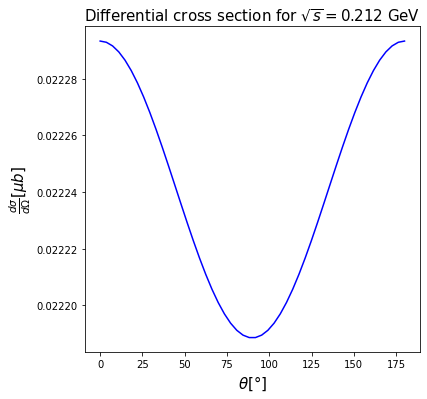

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
theta = np.linspace(0,np.pi)
ax.plot(theta*deg, diff_cross_section(E,theta),color='blue', label='PDF')

plt.title(r'Differential cross section for $\sqrt{s}=$'+str('%.3f' % E)+str(" GeV"), fontsize=15)
plt.xlabel(r'$ \theta [°] $', fontsize=15)
plt.ylabel(r'$ \frac{d\sigma}{d\Omega} [\mu b]$', fontsize=15)
#plt.legend()
plt.show()

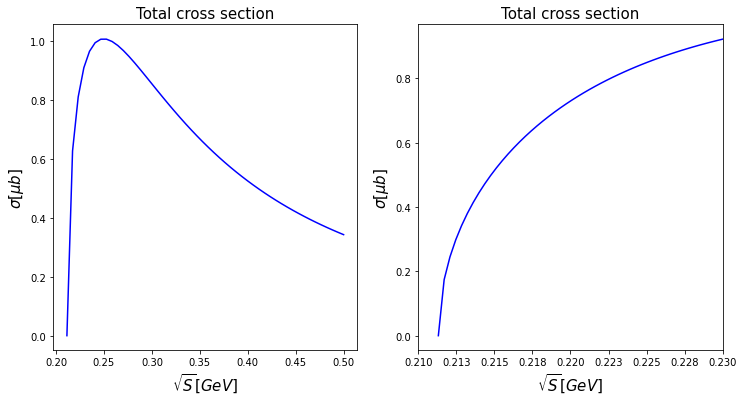

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
rs = np.linspace(2*muon_mass, 0.5)
ax1.plot(rs, cross_section(rs),color='blue', label='PDF')

ax1.set_title('Total cross section', fontsize=15)
ax1.set_xlabel(r'$ \sqrt{S} [GeV]$', fontsize=15)
ax1.set_ylabel(r'$ \sigma [\mu b]$', fontsize=15)

rs = np.linspace(2*muon_mass, 0.23)
ax2.plot(rs, cross_section(rs),color='blue', label='PDF')

ax2.set_title('Total cross section', fontsize=15)
ax2.set_xlabel(r'$ \sqrt{S} [GeV]$', fontsize=15)
ax2.set_ylabel(r'$ \sigma [\mu b]$', fontsize=15)
ax2.set_xlim(0.21,0.23)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.show()

Angular distribution


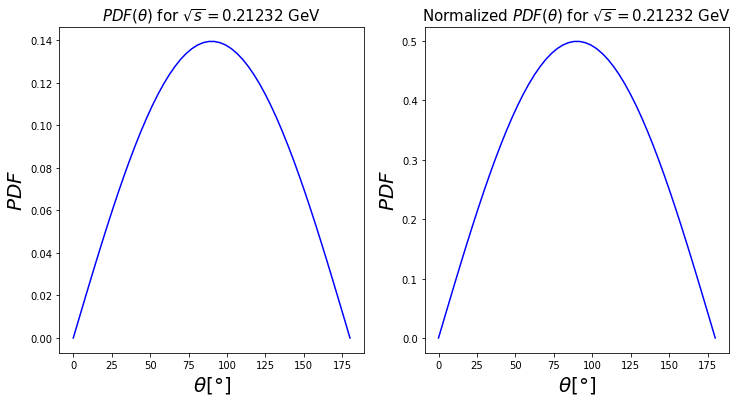

Check the normalization
Integral of the PDF in [0,pi] 0.27927
Integral of the normalized PDF in [0,pi] 1.00000


In [10]:
print('Angular distribution')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

theta = np.linspace(0, np.pi)


ax1.plot(theta*deg, pdf_theta(E,theta),color='blue', label='PDF')
ax1.set_title(r'$ PDF(\theta)$ for $\sqrt{s}=$'+str('%.5f' % E)+str(" GeV"), fontsize=15)
ax1.set_xlabel(r'$ \theta [°] $', fontsize=20)
ax1.set_ylabel(r'$ PDF$', fontsize=20)
#plt.legend()



ax2.plot(theta*deg, pdf_theta_normalized(E,theta),color='blue', label='PDF')
ax2.set_title(r'Normalized $ PDF(\theta)$ for $\sqrt{s}=$'+str('%.5f' % E)+str(" GeV"), fontsize=15)
ax2.set_xlabel(r'$ \theta [°] $', fontsize=20)
ax2.set_ylabel(r'$ PDF$', fontsize=20)
plt.show()

print('Check the normalization')
x2 = lambda x: pdf_theta(E,x)
print('Integral of the PDF in [0,pi]', "{:.5f}".format(integrate.quad(x2, 0., np.pi)[0]))
x2 = lambda x: pdf_theta_normalized(E,x)
print('Integral of the normalized PDF in [0,pi]', "{:.5f}".format(integrate.quad(x2, 0., np.pi)[0]))

## Monte Carlo Simulation

4. write a Monte Carlo simulation that generates scattering events following the distrubtions that you found analytically; 
5. produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be listed as rows in a file with columns representing the muons coordinates (keep in mind that in the lab frame muons are relativistic and thus the number of coordinates can be only 3 per muon);


In [11]:
#
###
####
#####
######
#######
######
#####
###
##
#

In [12]:
# In order to sample theta angles, we have taken the inverse cumulative density function transform approach.

def inv_cdf(rs,r):
    '''Takes a CoM energy rs in GeV, and an array r of U(0,1) samples to generate an array of theta samples distributed according to the scattering pdf.\n
    Also admits an array of energies of the same size of the sample array.'''
    s = rs**2
    p = 3*(s+4*muon_mass**2)/(s-4*muon_mass**2)
    q = 4*(2*r-1)*(s+2*muon_mass**2)/(s-4*muon_mass**2)
    h = p**3/27+q**2/4
    cos_t = np.cbrt(-q/2+np.sqrt(h))+np.cbrt(-q/2-np.sqrt(h))
    rand_theta = np.arccos(cos_t)

    return rand_theta

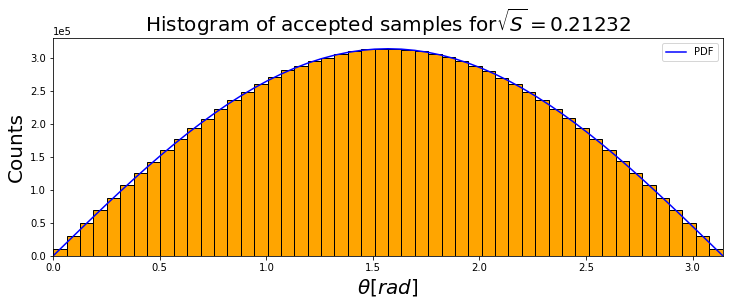

In [13]:
# Plot scaled histogram
fig, ax = plt.subplots(figsize=(12,4))

n, bins, _ = ax.hist(inv_cdf(E,np.random.random(N)), bins=50, color='orange', ec='black')

d = (bins[1]-bins[0])
scaling = d * n.sum()
ax.plot(bins, pdf_theta_normalized(E,bins)*scaling, color='blue', label='PDF')

plt.title('Histogram of accepted samples for'r'$ \sqrt{S}=$'+str('%.5f' % E), fontsize=20)
plt.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
plt.xlim(0.,np.pi)
plt.xlabel(r'$ \theta [rad]$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.legend()
plt.show()

To check that the distributions we are using are correct we compared them with Babayaga Event Generator [https://www2.pv.infn.it/~hepcomplex/babayaga.html] using as inputs the following values:

* final state = mm 
* ecms        = 0.2120 GeV
* thmin       = 0.0000 deg
* thmax       = 180.0000 deg
* acoll.      = 10.0000 deg
* emin        = 0.0000 GeV
* ord         = exp   
* model       = matched   
* nphot mode  = -1
* seed        = 700253512
* iarun       = 1
* eps         = .000500000
* darkmod     =    0


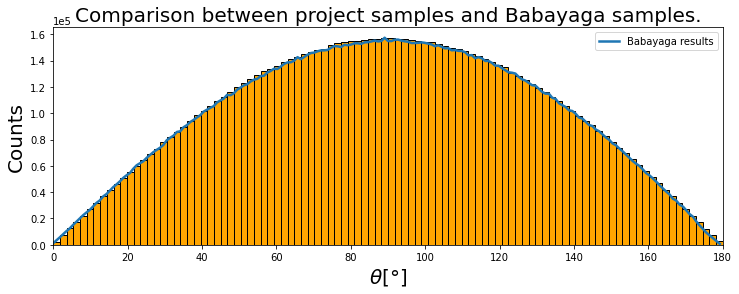

In [14]:
#Comparison with BabaYaga algorithm

file_data = np.loadtxt('matched_ep_th_exp_200.txt', usecols=(0,1,2))

theta_bby,dcs = file_data[:,0],file_data[:,1]
centroid = theta_bby + (theta_bby[0] + theta_bby[1])/2
dcs = dcs / ((theta[1] - theta[0])*dcs).sum()
dcs =dcs/np.max(dcs)



fig, ax = plt.subplots(figsize=(12,4))

n, bins, _ = ax.hist(inv_cdf(E,np.random.random(N))*deg, bins=100, color='orange', ec='black')
ax.plot(theta_bby,dcs*np.max(n), linewidth=2.5, label='Babayaga results')

plt.title('Comparison between project samples and Babayaga samples.', fontsize=20)
plt.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
plt.xlim(0.,180)
plt.xlabel(r'$ \theta [°]$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.legend()



plt.show()

In [15]:
#
###
####
#####
######
####### SIMULATION 1
######
#####
###
##
#

In [16]:
##################################################################################
#Simulation parameters

delta = 0.001
E = 2 * muon_mass + delta  #This is the proposed energy just above the threshold
N = 10**7

###################################################################################

In [17]:
#Obtain the parameters distribution
theta_instances = inv_cdf(E,np.random.random(N))
#N_instances     = len(theta_instances)
phi_instances   = np.random.uniform(0., 2*np.pi, N)

#The resulting space-momentum magnitude for each muon is the square of half the com energy minus the square of the muon mass.
p = np.sqrt(E**2/4-muon_mass**2)

In [18]:
#Obtain the muons momenta and build the file  (Is it in the CoM frame?)

def sph_to_cart(r,theta,phi):
    '''Converts from spherical coordinates to cartesian coordinates'''
    V = np.vstack([
        r*np.sin(theta)*np.cos(phi),
        r*np.sin(theta)*np.sin(phi),
        r*np.cos(theta)
    ])
    return V

pxm, pym, pzm = sph_to_cart(p, theta_instances, phi_instances)

pxam = -pxm
pyam = -pym
pzam = -pzm

In [19]:
from IPython.display import Math
#Write the results to a file

#print(r'$\sqrt(s)$', '%.5f' % E, "GeV")
display(Math('\sqrt s \qquad\qquad\!\!{} \,\,\, GeV'.format(round(E,5))))
print('Norm of p ', '%.5f' % p, "GeV")
#file_name='muons_momentum_com.csv'
#data=pd.read_csv(file_name)
#data

<IPython.core.display.Math object>

Norm of p  0.01029 GeV


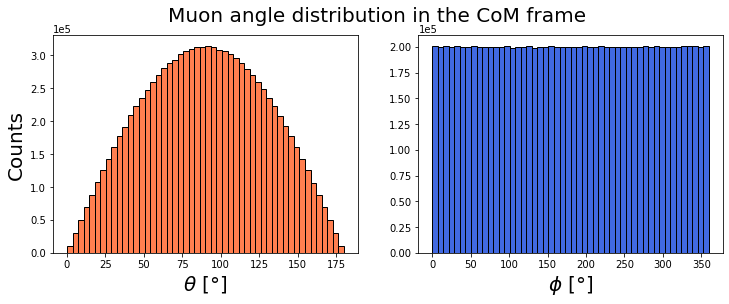

In [20]:
plot_angles_hist(theta_instances*deg, phi_instances*deg,'coral','royalblue','Muon angle distribution in the CoM frame')

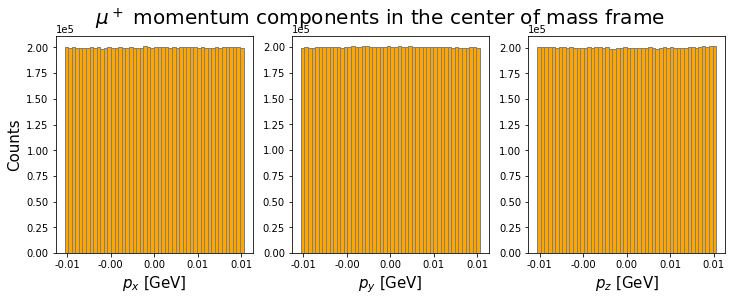

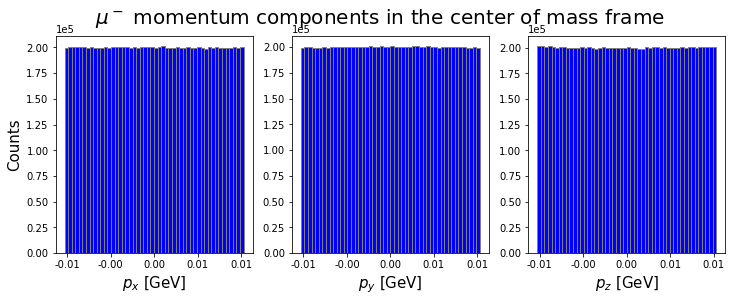

In [21]:
plot_momenta_hist(pxm,pym,pzm,r'$\mu^+$ momentum components in the center of mass frame','orange')
plot_momenta_hist(pxam,pyam,pzam,r'$\mu^-$ momentum components in the center of mass frame','blue')

<img src="img/comframe.svg" width="600" style="float: left;">

The Lab frame is the frame where the electrons are at rest, and thus considered to be the target. It is by means of Lorentz boosts that we will transform the simulated data from the center of mass frame to the laboratory frame.

The generic boost in a frame moving with velocity $u$ in the $Z$ direction is:

$$\Lambda = \left(\begin{array}{c c c c}
           \gamma & 0 & 0 & -u\gamma \\
           0 & 1  & 0 & 0 \\
           0    &  0      & 1 & 0 \\
           -u\gamma     &  0       & 0 & \gamma \\ 
\end{array}\right)$$

In this case, the electron's rest reference frame moves with speed $v$ in the negative $Z$ direction of the Center of mass frame. Therefore, the Lorentz Matrix becomes:

$$\Lambda = \left(\begin{array}{c c c c}
           \gamma & 0 & 0 & v\gamma \\
           0 & 1  & 0 & 0 \\
           0    &  0      & 1 & 0 \\
           v\gamma     &  0       & 0 & \gamma \\ 
\end{array}\right)$$

We can derive the magnitude of this velocity from the definition of relativistic momentum:

$$p=m_e\gamma v\to v\gamma = \frac{p}{m_e}\to \frac{v}{\sqrt{1-v^2}}=\frac{p}{m_e}\to v= \frac{p}{m_e\sqrt{1+\frac{p^2}{m_e^2}}}=\frac{p}{\sqrt{m_e^2 + p^2}}$$

Notice that the energy of the particle in the CoM is $E_p=\sqrt{m_e^2+p^2}$, which is half of the energy in the CoM frame. Thus

$$\begin{align}E^2_{CM}&=4m_e^2+4p^2\end{align}$$

then v becomes:
$$v=\sqrt{  \frac{E^2_{CM}-4m_e^2}{E^2_{CM}}  }$$

In [22]:
################################################

To boost from the CoM frame to the Lab frame the Lorentz matrix is the following:

$$\Lambda = \left(\begin{array}{c c c c}
           \gamma & 0 & 0 & v\gamma \\
           0 & 1  & 0 & 0 \\
           0    &  0      & 1 & 0 \\
           v\gamma     &  0       & 0 & \gamma \\ 
\end{array}\right),\qquad\qquad v=\sqrt{  \frac{E^2_{CM}-4m_e^2}{E^2_{CM}}  }$$

To get the momenta of the muons in the Lab frame we need to apply the Lorentz matrix to their 4-momenta:

$$\Lambda^\mu_\nu P^\nu = P'^\mu$$

Where $P^\nu$ is the 4 momentum before the boosting (in the COM frame) and $P'^\nu$ is the 4 momentum after the boosting (in the LAB frame)

$$P=\left(\begin{array}{c}m\gamma \\ p\cos\varphi \\ p\sin\varphi\sin\vartheta \\ p\sin\varphi\cos\vartheta\end{array}\right)$$


$$P'=\left(\begin{array}{c c c c}
           \gamma & 0 & 0 & v\gamma \\
           0 & 1  & 0 & 0 \\
           0    &  0      & 1 & 0 \\
           v\gamma     &  0       & 0 & \gamma \\ 
\end{array}\right)\left(\begin{array}{c}m\gamma \\ p\cos\varphi \\ p\sin\varphi\sin\vartheta \\ p\sin\varphi\cos\vartheta\end{array}\right)=\left(\begin{array}{c}m\gamma^2 + \gamma vp\cos\vartheta \\ p\cos\varphi \\ p\sin\vartheta\\ m\gamma^2 v + \gamma p\cos\vartheta \end{array}\right)$$

During a Lorentz Boost in the z direction $\varphi$ does not change, but $\vartheta$ does. From the matricial equation above we can get the relationship $\vartheta\leftrightarrow\vartheta'$ the angle of the scattered particle before and after the boosts:

$$\begin{cases}
    m\gamma^2v+\gamma p\cos\vartheta = p'\cos\vartheta' \\
    p\sin\vartheta = p\sin\vartheta'
\end{cases}$$

Writing $m\gamma^2 v$ as $\gamma p$ we have:

$$\begin{cases}
    \gamma p +\gamma p\cos\vartheta = p'\cos\vartheta' \\
    p\sin\vartheta = p\sin\vartheta'
\end{cases}$$

Dividing the first to the second we get:
 $$\tan\vartheta'=\frac{1}{\gamma}\left(\frac{\sin\vartheta}{1+\cos\vartheta}\right)$$

In [23]:
#Boost the results to the laboratory frame
def boost(v_i,x_0,x_i):
    g = 1/np.sqrt(1-v_i**2)
    b_x_0 = g*(x_0-v_i*x_i)
    b_x_i = g*(x_i-v_i*x_0)
    return b_x_0, b_x_i

vz = -np.sqrt(1-4*electron_mass**2/E**2)   
gamma = 1/np.sqrt(1-vz**2)

In [24]:
print('Gamma', '%.5f' % gamma)
print('Speed along z axis (vz)', '%.5f' % vz)

Gamma 207.74676
Speed along z axis (vz) -0.99999


In [25]:
pxm_lb = pxm
pym_lb = pym
E_lb, pzm_lb = boost(vz,E/2,pzm)

pxam_lb = pxam 
pyam_lb = pyam
_, pzam_lb = boost(vz,E/2,pzam)

In [26]:
#Check the file

#print(r'$\sqrt(s)$', '%.5f' % E, "GeV")
display(Math('\sqrt s \qquad\quad\,{} \,\,\, GeV'.format(round(E,5))))
print('Norm of p', '%.5f' % p, "GeV")
#file_name='/home/usuario/PoD/muons_momentum_lab.csv'
#data=pd.read_csv(file_name)
#data

<IPython.core.display.Math object>

Norm of p 0.01029 GeV


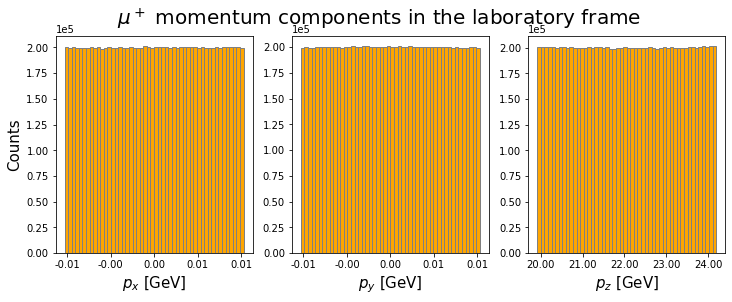

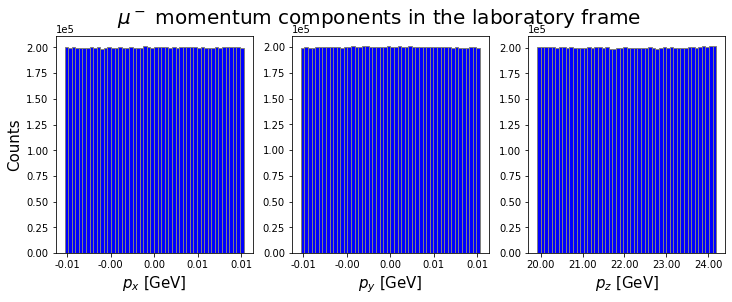

In [27]:
plot_momenta_hist(pxm_lb,pym_lb,pzm_lb,r'$\mu^+$ momentum components in the laboratory frame','orange')
plot_momenta_hist(pxm_lb,pym_lb,pzm_lb,r'$\mu^-$ momentum components in the laboratory frame','blue')

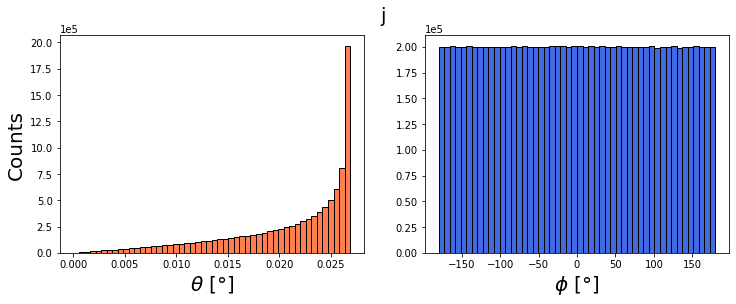

Maximum theta according to the theory [Antonelli] 0.02674 deg
Maximum theta in the simulation                   0.02686 deg


In [28]:
theta_lb = np.arccos(pzm_lb/np.sqrt(pxm_lb**2+pym_lb**2+pzm_lb**2))
phi_lb = np.arctan2(pym_lb,pxm_lb)

plot_angles_hist(theta_lb*deg, phi_lb*deg, 'coral','royalblue','j')

theta_max_t = 4 * electron_mass /E **2 * np.sqrt(E **2 /4. -muon_mass**2)
print('Maximum theta according to the theory [Antonelli]', "{:.5f}".format(theta_max_t*deg), "deg")
print('Maximum theta in the simulation                  ', "{:.5f}".format(np.max(theta_lb)*deg), "deg")

In [29]:
p_cm = -E**2/4 + pxm**2+pym**2+pzm**2
print('Squared four momentum in the CM frame',p_cm)

p_lb = -E_lb**2 + pxm_lb**2+pym_lb**2+pzm_lb**2
print('Squared four momentum in the LB frame',p_lb)

print('Muon energy in the laboratory frame',E_lb)

Squared four momentum in the CM frame [-0.01116369 -0.01116369 -0.01116369 ... -0.01116369 -0.01116369
 -0.01116369]
Squared four momentum in the LB frame [-0.01116369 -0.01116369 -0.01116369 ... -0.01116369 -0.01116369
 -0.01116369]
Muon energy in the laboratory frame [23.4228242  21.78460856 23.73571471 ... 20.59628369 24.10518769
 24.14060688]


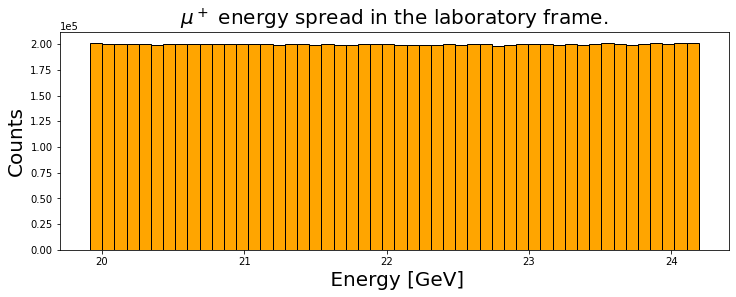

Difference between max and min energy of the muons according to the theory [Antonelli] 2.13796 GeV

Difference between max and min energy of the muons 4.27587 GeV


In [30]:
#Visualization of the energy spread

fig, ax = plt.subplots(figsize=(12,4))

n, bins, _ = ax.hist(E_lb, bins=50, color='orange', ec='black')
plt.title(r'$\mu^+$ energy spread in the laboratory frame.', fontsize=20)
plt.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
plt.xlabel(' Energy [GeV]', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.show()

de_max_t = E / (2*electron_mass) * np.sqrt(E **2 /4 - muon_mass**2)
print('Difference between max and min energy of the muons according to the theory [Antonelli]', "{:.5f}".format(de_max_t), "GeV")
print('')
print('Difference between max and min energy of the muons', "{:.5f}".format(np.max(E_lb)-np.min(E_lb)), "GeV")

In [31]:
#Write the results to a file 

s1_muons_com = pd.DataFrame({'Theta' : theta_instances,'Phi' : phi_instances,'Muon px' : pxm, 'Muon py' : pym, 'Muon pz' : pzm})
#s1_muons_com.to_csv('s1_muons_momentum_com.csv', index=False)

s1_muons_lab = pd.DataFrame({'Theta' : theta_lb,'Phi' : phi_lb,'Muon px' : pxm_lb, 'Muon py' : pym_lb, 'Muon pz' : pzm_lb})
#s1_muons_lab.to_csv('s1_muons_momentum_lab.csv', index=False)

In [32]:
#
###
####
#####
######
#######
######
#####
###
##
#

## Properties of the target 
6. assume a $3$ cm thick Beryllium block is used as target and a rate of positron on target of $10^6$ Hz. Compute the rescaling factor (weight) you need to apply to the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations;


The number of $\mu^+ \mu^-$ pairs produced per positron on the target is given by:


$$n(\mu^+ \mu^-) = n^+ \rho^- l \sigma(\mu^+ \mu^-)$$


where $n^+$ is the number of positrons, $\rho^-$ is the electron density in the medium, $l$ is the thickness of the target, and $\sigma(\mu^+ \mu^-)$ is the muon pairs production cross section. [Antonelli]





In [33]:
#We build a dataframe with some material properties to be analysed

Material = ['H',    'He',   'Li',  'Be',    'B',    'C',     'Cu',   'W',    'Pb']
Z        = [ 1 ,     2,      3,     4,       5,      6,       29,     74,     82]
A        = [1.00794, 4.0026, 6.941, 9.01218, 10.811, 12.0107, 63.546, 183.84, 207.2]
X0       = [900.6,   786,    156.2, 35.2,    22.2,   21.4,    1.4,    0.4,    0.6]

properties_dic = {'Material': Material, 'Z': Z, 'A': A, 'X0': X0}
properties = pd.DataFrame(data=properties_dic)
properties


,Material,Z,A,X0
0,H,1,1.00794,900.6
1,He,2,4.00260,786.0
2,Li,3,6.94100,156.2
3,Be,4,9.01218,35.2
4,B,5,10.81100,22.2
5,C,6,12.01070,21.4
6,Cu,29,63.54600,1.4
7,W,74,183.84000,0.4
8,Pb,82,207.20000,0.6


In [34]:
######
#Realistic target
positron_frequency = 1.e6                     #[Hz]
target_length      = 3                        #[cm]
cs                 = cross_section(E)*10.e-31 #[uBarn]--> [cm^2]
time               = 60 * 60 *24 *7           #[secconds]


properties['L'] = target_length
properties['Cross section'] = cs


#Number of positrons 
N_positrons = positron_frequency * time 

#Number of muons
properties['N_muons'] = N_positrons * (properties['Z']*Avogadro_number/properties['A']) * properties['Cross section'] * properties['L']

#Weight
rf = properties.at[3,'N_muons']/N
####

In [35]:
properties

,Material,Z,A,X0,L,Cross section,N_muons
0,H,1,1.00794,900.6,3,2.792678e-31,302740.227535
1,He,2,4.00260,786.0,3,2.792678e-31,152472.885096
2,Li,3,6.94100,156.2,3,2.792678e-31,131887.617753
3,Be,4,9.01218,35.2,3,2.792678e-31,135436.258460
4,B,5,10.81100,22.2,3,2.792678e-31,141126.623320
5,C,6,12.01070,21.4,3,2.792678e-31,152436.070308
6,Cu,29,63.54600,1.4,3,2.792678e-31,139256.216966
7,W,74,183.84000,0.4,3,2.792678e-31,122827.757211
8,Pb,82,207.20000,0.6,3,2.792678e-31,120761.615662


In [36]:
print('Number of positrons produced in a week                                 '"{:.2e}".format( N_positrons))
print('')
print('Number of simulated events                                             '"{:.2e}".format( N ))
print('')
print('Rescaling factor if using Be as a target', '%.5f' % rf)
print('')
print('Number of muons produced after a week using Be as a target             '"{:.2e}".format( properties.at[3,'N_muons']))

Number of positrons produced in a week                                 6.05e+11

Number of simulated events                                             1.00e+07

Rescaling factor if using Be as a target 0.01354

Number of muons produced after a week using Be as a target             1.35e+05


In [37]:
#
###
####
#####
######
####### 
######
#####
###
##
#

## Properties of  the beam
7. repeat what done so far simulating now the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV;

In [38]:
##################################################################################
#Simulation parameters

N = 10**7  #Number of positrons
E_lab = 45  #GeV
sigma = 0.5 # mean and standard deviation

###################################################################################

In [39]:
#Realistic beam
#Up to this point we have been assuming that the energy of the incident 
#beam had a constant value, now we want to make a model where the energy
#of the beam has a gaussian distribution.

E_lab_instances = np.random.normal(E_lab, sigma, N)

#Now we need to boost them to the CoM frame
vz    = np.sqrt((E_lab-electron_mass)/(E_lab+electron_mass))
gamma = 1/np.sqrt(1-vz**2)

E_cm_instances = 2 *gamma*(E_lab_instances-vz*np.sqrt(E_lab_instances**2-electron_mass**2))

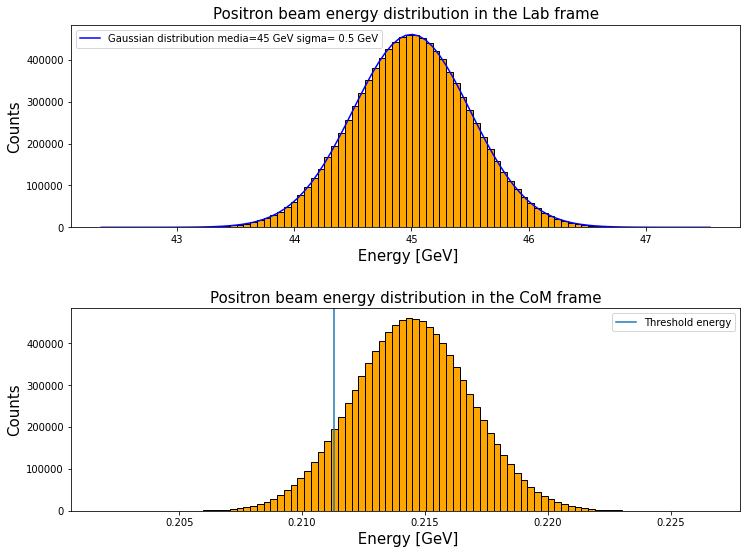

In [40]:
#Plot scaled histogram
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

n, bins, _ = ax1.hist(E_lab_instances, bins=90,color='orange', ec='black')

d = (bins[1]-bins[0])
scaling = d * n.sum()

ax1.plot(bins, scaling/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - E_lab)**2 / (2 * sigma**2) ),color='blue', label='Gaussian distribution media=45 GeV sigma= 0.5 GeV')

ax1.set_title('Positron beam energy distribution in the Lab frame', fontsize=15)
ax1.set_xlabel(' Energy [GeV]', fontsize=15)
ax1.set_ylabel('Counts', fontsize=15)
ax1.legend()

n, bins, _ = ax2.hist(E_cm_instances, bins=90,color='orange', ec='black')

d = (bins[1]-bins[0])
scaling = d * n.sum()

ax2.axvline(x=2*muon_mass, label='Threshold energy')
ax2.set_title('Positron beam energy distribution in the CoM frame', fontsize=15)
ax2.set_xlabel(' Energy [GeV]', fontsize=15)
ax2.set_ylabel('Counts', fontsize=15)
ax2.legend()

plt.subplots_adjust(top=0.8, wspace=0.4, hspace=0.4)

plt.show()

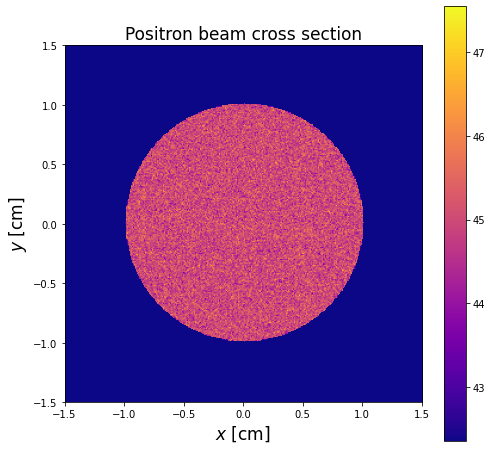

In [41]:
#Once we have the energy distribution plot a heatmap of the beam

def circular_section(data):
    
    # specify circle parameters: centre ij and radius
    pixels =len(data[0,:])
    ci,cj = pixels/2 , pixels/2
    cr=pixels/3

    # Create index arrays to z
    I,J=np.meshgrid(np.arange(data.shape[0]),np.arange(data.shape[1]))

    # calculate distance of all points to centre
    dist=np.sqrt((I-ci)**2+(J-cj)**2)

    # Assign value of 1 to those points where dist<cr:
    data[np.where(dist>cr)]=0
    return data



pixels=300
size  =(-1.5,1.5,-1.5,1.5)

# We randomly pick (pixel x pixels) elements of the energy distribution to plot the beam cross section

z = np.random.choice(E_lab_instances, size=(pixels,pixels), replace=True, p=None) 


plt.rcParams["figure.figsize"] = (8,8)
plt.imshow(circular_section(z),cmap='plasma', extent=(size),origin='lower')
plt.title('Positron beam cross section',fontsize=17)
plt.ylabel(r'${y}$ [cm]',fontsize=17)  
plt.xlabel(r'${x}$ [cm]',fontsize=17)
plt.colorbar()
plt.clim(np.min(E_lab_instances),np.max(E_lab_instances))
plt.show()

In [42]:
#
###
####
#####
######
####### SIMULATION 2
######
#####
###
##
#

In [43]:
##################################################################################
#Simulation parameters

N     = 10**6 #Number of positrons 
E_lab = 45    #GeV
sigma = 0.5   # mean and standard deviation

###################################################################################

In [44]:
##Now that we have the energy distributions and also an idea of the shape
##we can repeat the previous part

#Obtain the positron energy samples in the laboratory frame
E_lab_samples = np.random.normal(E_lab, sigma, N)

#Boost of the positrons energy to the Center of Mass Frame
vz    = np.sqrt((E_lab-electron_mass)/(E_lab+electron_mass))
gamma = 1/np.sqrt(1-vz**2)

E_cm_samples = 2 *gamma*(E_lab_samples-vz*np.sqrt(E_lab_samples**2-electron_mass**2))

#Filter the values below the threshold
E_cm_samples = E_cm_samples[E_cm_samples> 2* muon_mass]

N_instances = len(E_cm_samples)

theta_cm_instances = inv_cdf(E_cm_samples,np.random.random(N_instances))

phi_cm_instances   = np.random.uniform(0., 2*np.pi, N_instances)

In [45]:
#Calculate the total momentum p       CM
#Calculate the momentum components in CM
p_cm_instances = np.sqrt(E_cm_samples**2/4-muon_mass**2)

pxm_cm, pym_cm, pzm_cm = sph_to_cart(p_cm_instances,theta_cm_instances,phi_cm_instances) 
#Calculate the momentum components in LAB
vz = -np.sqrt(1-4*electron_mass**2/E_cm_samples**2)   
gamma = 1/np.sqrt(1-vz**2)

pxm_lb = pxm_cm
pym_lb = pym_cm
pzm_lb = gamma * pzm_cm - vz * gamma *E_cm_samples/2

#Calculate the total momentum p       LAB
#Obtain the angles thet and phi       LAB
p_lb_instances = np.sqrt(pxm_lb**2 + pym_lb**2 + pzm_lb**2)

theta_lb_instances = np.arccos(pzm_lb/p_lb_instances)
phi_lb_instances   = np.arctan2(pym_lb,pxm_lb)

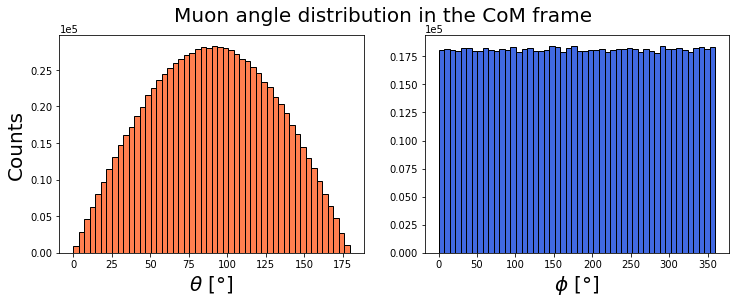

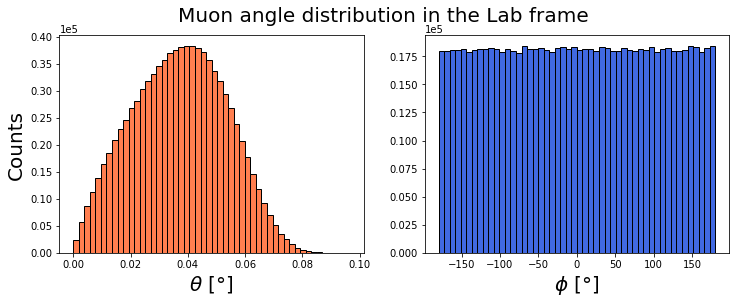

Maximum theta according to the theory [Antonelli] 0.09371 deg
Maximum theta in the simulation                   0.09660 deg
The media for the theta angle                     0.03709 deg


In [46]:
plot_angles_hist(theta_cm_instances*deg,phi_cm_instances*deg,'coral','royalblue','Muon angle distribution in the CoM frame')
plot_angles_hist(theta_lb_instances*deg,phi_lb_instances*deg,'coral','royalblue','Muon angle distribution in the Lab frame')

theta_max_t = 4 * electron_mass /np.max(E_cm_samples) **2 * np.sqrt(np.max(E_cm_samples) **2 /4. -muon_mass**2)
print('Maximum theta according to the theory [Antonelli]', "{:.5f}".format(theta_max_t*deg), "deg")
print('Maximum theta in the simulation                  ', "{:.5f}".format(np.max(theta_lb_instances)*deg), "deg")
print('The media for the theta angle                    ', "{:.5f}".format(np.average(theta_lb_instances)*deg), "deg")

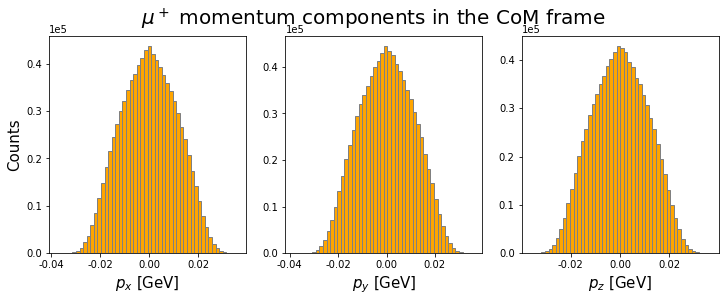

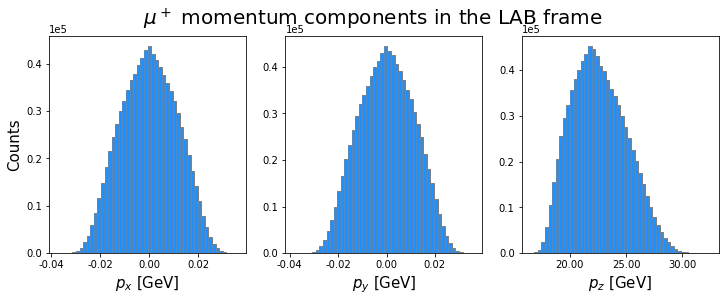

In [47]:
plot_momenta_hist(pxm_cm,pym_cm,pzm_cm,r'$\mu^+$ momentum components in the CoM frame','orange')
plot_momenta_hist(pxm_lb,pym_lb,pzm_lb,r'$\mu^+$ momentum components in the LAB frame','dodgerblue')

In [48]:
#Check of the four momenta
p_cm = -E_cm_samples**2/4 + pxm_cm**2+pym_cm**2+pzm_cm**2
print('Squared four momentum in the CM frame',p_cm)

E_lb = gamma*(E_cm_samples/2-pzm_cm*vz)
p_lb = -E_lb**2 + pxm_lb**2+pym_lb**2+pzm_lb**2
print('Squared four momentum in the LB frame',p_lb)

Squared four momentum in the CM frame [-0.01116369 -0.01116369 -0.01116369 ... -0.01116369 -0.01116369
 -0.01116369]
Squared four momentum in the LB frame [-0.01116369 -0.01116369 -0.01116369 ... -0.01116369 -0.01116369
 -0.01116369]


In [49]:
#Write the results to a file 

s2_muons_com = pd.DataFrame({'Theta' : theta_cm_instances,'Phi' : phi_cm_instances,'Muon px' : pxm_cm, 'Muon py' : pym_cm, 'Muon pz' : pzm_cm})
#s2_muons_com.to_csv('s2_muons_momentum_com.csv', index=False)

s2_muons_lab = pd.DataFrame({'Theta' : theta_lb_instances,'Phi' : phi_lb_instances,'Muon px' : pxm_lb, 'Muon py' : pym_lb, 'Muon pz' : pzm_lb})
#s2_muons_lab.to_csv('s2_muons_momentum_lab.csv', index=False)

## Aditional considerations

8. given that the electrons traversing the target lose energy as $E(z)=E_0 \exp{-z/X_0}$ (with z the longitudinal coordinate of the target, the one parallel to the beam direction and $X_0$ is the Beryllium radiation length), compute the nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target;
9. (optional) take the former point into account when generating the events (i.e. the proccess $\sqrt{s}$ depend on the position along the target where the $e^+ - e^-$ scattering occurrs.



The threshold energy in the center of mass frame is $E_{t CoM} = 2 m_\mu$. As the law for the energy decay  is given in the laboratory frame where the Beryllium target has a length of 3 cm we boost $E_{threshold CoM}$ to the laboratory frame where the electron is at rest and the positron has all the kinetic energy.

$$E_{tLab} = m_e \gamma ^2 + \gamma v p$$

Where $$\gamma =\frac{1}{\sqrt{1-v^2}}$$ and $$v = \sqrt{\frac{E_{t CoM}^2-4m_e^2}{E_{t CoM}^2}}$$

Using the identity $m\gamma^2v =\gamma p$ to write all in term of the masses $m_\mu$ and $m_e$ obtaining as a result:
$$E_{tLab} = 2\frac{m_\mu^2}{m_e}-m_e$$

$$E_{tLab} \sim 43.6931 \,\,\,GeV$$

Now the nominal beam energy can be obtained solving the equation for the energy decay in the target:

$$E_{0 lab} = E_{tLab} e^{l/X_0}$$

Taking a target length of $l=3$cm and the Beryllium radiation length as $X_0 = 35.2$ cm we obtain the nominal beam energy: 

$$E_{0 lab} \sim 47.58 \,\,\,GeV$$ 

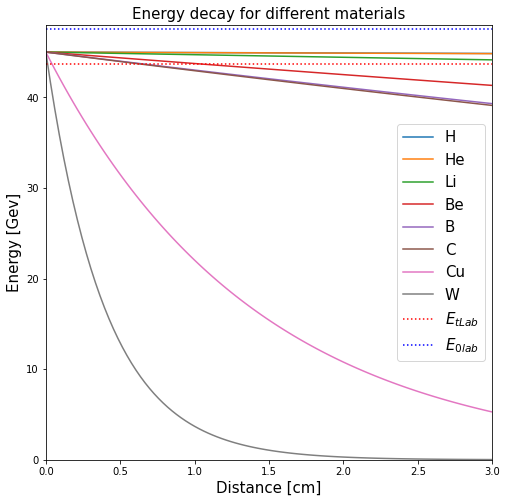

In [50]:
#Plots of energy decay for different materials
x = np.linspace(0,3,num=100)
for i in range(0,8):
    plt.plot(x, 45 * np.exp(-x/properties.at[i,'X0']),label = properties.at[i,'Material'])
    
plt.axhline(y=43.6931, color='r', linestyle=':',label =r'$E_{tLab}$')
plt.axhline(y=47.58, color='b', linestyle=':',label =r'$E_{0 lab}$')
plt.title('Energy decay for different materials', fontsize=15)
plt.xlabel('Distance [cm]', fontsize=15)
plt.xlim(0.,3.)
plt.ylabel('Energy [Gev]', fontsize=15)
plt.ylim(0.,48.)
plt.legend(fontsize=15)
plt.show()

In [51]:
#
###
####
#####
######
####### SIMULATION 3
######
#####
###
##
#

In [52]:
##################################################################################
#Simulation parameters

N     = 10**6 #Number of positrons
E_lab = 47.58    #[GeV]
sigma = 0.5   # mean and standard deviation

###################################################################################

In [53]:
#Obtain the positron energy samples in the laboratory frame
E_lab_samples = np.random.normal(E_lab, sigma, N)

#We keep the distribution for ploting purposes
E_lab_plot = E_lab_samples 

#Now we distribute the energies according the position in the Beryllium plate
##########################################################################
x = np.random.uniform(low=0., high=target_length, size=(len(E_lab_samples),))
E_lab_samples = E_lab_samples*np.exp(-x/properties.at[3,'X0'])
##########################################################################

#Boost of the positrons energy to the Center of Mass Frame
vz    = np.sqrt((E_lab_samples-electron_mass)/(E_lab_samples+electron_mass))   
gamma = 1/np.sqrt(1-vz**2)

E_cm_samples = 2 *gamma*(E_lab_samples-vz*np.sqrt(E_lab_samples**2-electron_mass**2))

#Filter the values below the threshold
b = E_cm_samples[E_cm_samples> 2* muon_mass]

N_instances = len(b)

theta_cm_instances = inv_cdf(b,np.random.random(N_instances))

phi_cm_instances   = np.random.uniform(0., 2*np.pi, N_instances)

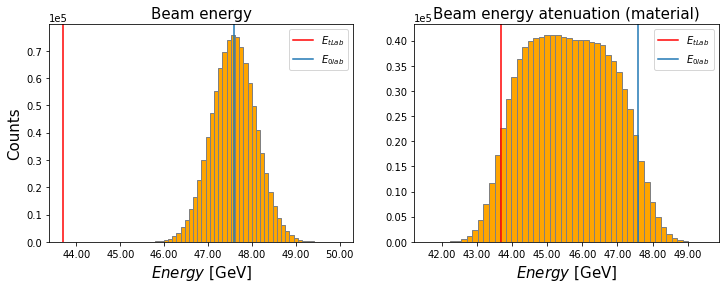

In [54]:
#Energy distributions
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

n, bins, _ = ax1.hist(E_lab_plot, bins=50,color='orange', ec='grey')
ax1.axvline(x=43.6931, color='r', label=r'$E_{tLab}$')
ax1.axvline(x=47.58, label=r'$E_{0 lab}$')
ax1.set_title('Beam energy', fontsize=15)
ax1.set_xlabel(r'$Energy$ [GeV]', fontsize=15)
ax1.set_ylabel('Counts', fontsize=15)
ax1.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend()


n, bins, _ = ax2.hist(E_lab_samples, bins=50,color='orange', ec='grey')
ax2.axvline(x=43.6931, color='r', label=r'$E_{tLab}$')
ax2.axvline(x=47.58, label=r'$E_{0 lab}$')
ax2.set_title('Beam energy atenuation (material)', fontsize=15)
ax2.set_xlabel(r'$Energy$ [GeV]', fontsize=15)
ax2.ticklabel_format(axis="y", style="sci", scilimits=(5,5))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend()

plt.show()

In [55]:
#Calculate the total momentum p       CM
#Calculate the momentum components in CM
p_cm_instances = np.sqrt(b**2/4-muon_mass**2)

pxm_cm, pym_cm, pzm_cm = sph_to_cart(p_cm_instances, theta_cm_instances, phi_cm_instances)

#Calculate the momentum components in LAB
vz = -np.sqrt(1-4*electron_mass**2/b**2)   
gamma = 1/np.sqrt(1-vz**2)

pxm_lb = pxm_cm
pym_lb = pym_cm
pzm_lb = gamma * pzm_cm - vz * gamma *b/2

#Calculate the total momentum p       LAB
#Obtain the angles thet and phi       LAB
p_lb_instances = np.sqrt(pxm_lb**2 + pym_lb**2 + pzm_lb**2)

theta_lb_instances = np.arccos(pzm_lb/p_lb_instances)
phi_lb_instances   = np.arctan2(pym_lb,pxm_lb)

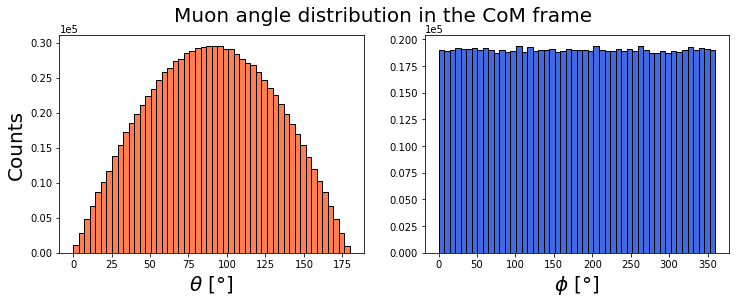

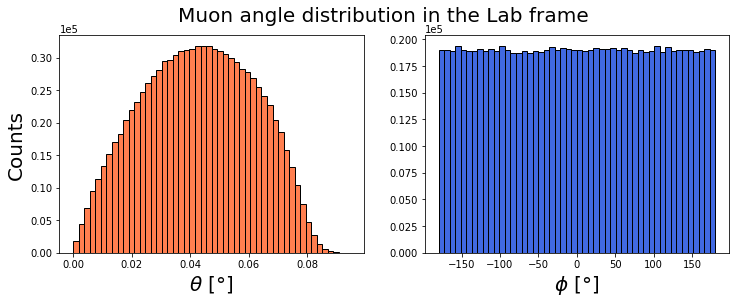

Maximum theta according to the theory [Antonelli] 0.08910 deg
Maximum theta in the simulation                   0.09455 deg
The media for the theta angle                     0.04271 deg


In [56]:
plot_angles_hist(theta_cm_instances*deg,phi_cm_instances*deg,'coral','royalblue','Muon angle distribution in the CoM frame')
plot_angles_hist(theta_lb_instances*deg,phi_lb_instances*deg,'coral','royalblue','Muon angle distribution in the Lab frame')

theta_max_t = 4 * electron_mass /np.max(b) **2 * np.sqrt(np.max(b) **2 /4. -muon_mass**2)
print('Maximum theta according to the theory [Antonelli]', "{:.5f}".format(theta_max_t*deg), "deg")
print('Maximum theta in the simulation                  ', "{:.5f}".format(np.max(theta_lb_instances)*deg), "deg")
print('The media for the theta angle                    ', "{:.5f}".format(np.average(theta_lb_instances)*deg), "deg")

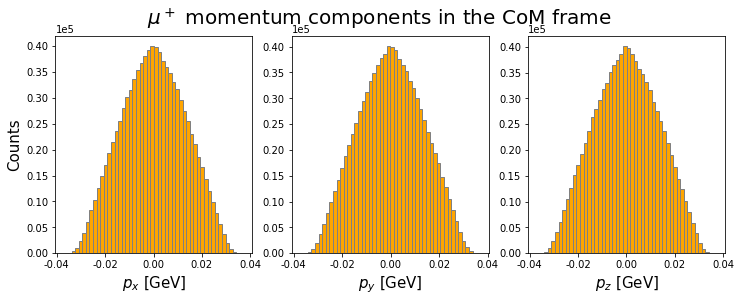

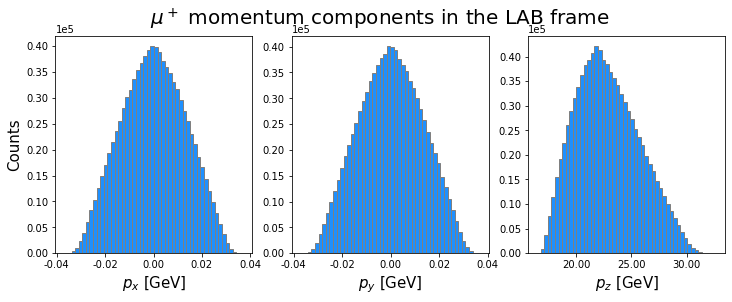

In [57]:
plot_momenta_hist(pxm_cm,pym_cm,pzm_cm,r'$\mu^+$ momentum components in the CoM frame','orange')
plot_momenta_hist(pxm_lb,pym_lb,pzm_lb,r'$\mu^+$ momentum components in the LAB frame','dodgerblue')

In [58]:
#Check of the four momenta
p_cm = -b**2/4 + pxm_cm**2+pym_cm**2+pzm_cm**2
print('Squared four momentum in the CM frame',p_cm)

E_lb = gamma*(b/2-pzm_cm*vz)
p_lb = -E_lb**2 + pxm_lb**2+pym_lb**2+pzm_lb**2
print('Squared four momentum in the LB frame',p_lb)

Squared four momentum in the CM frame [-0.01116369 -0.01116369 -0.01116369 ... -0.01116369 -0.01116369
 -0.01116369]
Squared four momentum in the LB frame [-0.01116369 -0.01116369 -0.01116369 ... -0.01116369 -0.01116369
 -0.01116369]


In [59]:
#Write the results to a file 

s3_muons_com = pd.DataFrame({'Theta' : theta_cm_instances,'Phi' : phi_cm_instances,'Muon px' : pxm_cm, 'Muon py' : pym_cm, 'Muon pz' : pzm_cm})
#s3_muons_com.to_csv('s3_muons_momentum_com.csv', index=False)

s3_muons_lab = pd.DataFrame({'Theta' : theta_lb_instances,'Phi' : phi_lb_instances,'Muon px' : pxm_lb, 'Muon py' : pym_lb, 'Muon pz' : pzm_lb})
#s3_muons_lab.to_csv('s3_muons_momentum_lab.csv', index=False)